In [1]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [3]:
#load data
train_data_10 = CIFAR10DataProvider('train', batch_size=128)
valid_data_10 = CIFAR10DataProvider('valid', batch_size=128)
#reshape data
train_data_10.inputs = train_data_10.inputs.reshape((40000, -1, 3), order='F')
train_data_10.inputs = train_data_10.inputs.reshape((40000, 32, 32, 3))
valid_data_10.inputs = valid_data_10.inputs.reshape((10000, -1, 3), order='F')
valid_data_10.inputs = valid_data_10.inputs.reshape((10000, 32, 32, 3))

In [2]:
def error_acc():
    list_train_error=[]
    list_train_acc=[]
    list_vald_error=[]
    list_vald_acc=[]
    with tf.Session() as sess:
        sess.run(init)
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data_10:
                start_time= time.time()
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data_10.num_batches
            running_accuracy /= train_data_10.num_batches
            if (e + 1) % 3 ==0:
                list_train_error.append(running_error)
                list_train_acc.append(running_accuracy)
                end_time= start_time - time.time()
                print('Completed time{0:.2f}s End of epoch {1:02d}: err(train)={2:.2f} acc(train)={3:.2f}'
                      .format(end_time, e + 1, running_error, running_accuracy))
            if (e + 1) % 3 == 0:
                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data_10:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data_10.num_batches
                valid_accuracy /= valid_data_10.num_batches
                list_vald_error.append(valid_error)
                list_vald_acc.append(valid_accuracy)
                print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                       .format(valid_error, valid_accuracy))
        return list_train_error,list_train_acc,list_vald_error,list_vald_acc

In [5]:
def two_cnv_fc_layer_maxwindow(inputs, AF,ksize,padding):
    with tf.variable_scope('conv1'):
        #first Conv layer
        #kernel is a 5x5 weights matrix for all 3 colors, used truncated to randomlize it
        conv_kernel_1 = tf.Variable(
        tf.truncated_normal(
        shape=[5, 5, 3, 32], stddev=0.05),'kernel')
        #do the convlove
        conv1 = tf.nn.conv2d(inputs, conv_kernel_1, [1, 1, 1, 1], padding='SAME')
        #define bias:0
        conv_bias_1 = tf.Variable(tf.zeros([32]), 'biases')
        conv1_add_bias = tf.nn.bias_add(conv1, conv_bias_1)
        #non_lineartity
        AF_conv1 = AF(conv1_add_bias)
        #pooling layer
        
    max_pool_1 = tf.nn.max_pool(AF_conv1, ksize=ksize, strides=[1, 2, 2, 1],
                                  padding=padding, name='pool1_layer')
        # normalization
    norm_1 = tf.nn.lrn(max_pool_1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm1')
    
    with tf.variable_scope('conv2') :
        #kernel is a 3x3 weights matrix for all 64 features, used truncated to randomlize it
        conv_kernel_2 = tf.Variable(
        tf.truncated_normal(
        shape=[5, 5, 32, 64], stddev=0.05),'kernel')
        #do the convlove
        conv2 = tf.nn.conv2d(norm_1, conv_kernel_2, [1, 1, 1, 1], padding='SAME')
        #define bias: 0
        conv_bias_2 = tf.Variable(tf.zeros([64]), 'biases')
        conv2_add_bias = tf.nn.bias_add(conv2, conv_bias_2)
        #apply non-lineartity
        AF_conv2 = AF(conv2_add_bias)
    # local-response-normalization
    norm_2 = tf.nn.lrn(AF_conv2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm2')
    #pooling
    max_pool_2 = tf.nn.max_pool(norm_2, ksize=ksize, strides=[1, 2, 2, 1],
                              padding=padding , name='pool2_layer')
    
    #reshape the image for fc-layers and get the dim
    reshaped_image = tf.reshape(max_pool_2, [-1,8*8*64])
    #reshaped_dim = reshaped_image.get_shape()[1].value
    #first fc-layer
    with tf.variable_scope('fc_layer1'):
        #let the hidden layer has 384 nodes
        fc_weights1 = tf.Variable(tf.truncated_normal(shape=[8*8*64,1024], stddev=0.05),
                                  'fc_weights1')
        fc_bias1 = tf.Variable(tf.zeros([1024]),'fc_bias1')
        Wx_b = tf.matmul(reshaped_image,fc_weights1) + fc_bias1
        Wx_b = tf.nn.dropout(Wx_b,keep_prob=0.5)
        fc_layer_1 = AF(Wx_b)
    #second fc-layer
    with tf.variable_scope('fc_layer2'):
        fc_weights2 = tf.Variable(tf.truncated_normal(shape=[1024,1024],stddev=0.05),
                                 'fc_weights2')
        fc_bias2 = tf.Variable(tf.zeros([1024]),'fc_bias2')
        Wx_b2 = tf.matmul(fc_layer_1,fc_weights2) + fc_bias2
        Wx_b2 = tf.nn.dropout(Wx_b2,keep_prob=0.5)
        fc_layer_2 = AF(Wx_b2)        
    #output layer
    with tf.variable_scope('fc_output'):
        fc_weights3 = tf.Variable(tf.truncated_normal(shape=[1024,train_data_10.num_classes],
                                                      stddev=0.05),'fc_weights3')
        fc_bias3 = tf.Variable(tf.zeros([train_data_10.num_classes]),'fc_bias3')
        outputs=AF(tf.add(tf.matmul(fc_layer_2,fc_weights3),fc_bias3))
    return outputs

In [6]:
inputs = tf.placeholder(tf.float32, [None, 32,32,3], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data_10.num_classes], 'targets')
with tf.name_scope('CNN'):
    outputs=two_cnv_fc_layer_maxwindow(inputs,AF=tf.nn.relu,ksize=[1,2,2,1],padding='SAME')
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
init = tf.global_variables_initializer()
train_error_2by2, train_acc_2by2,vald_error_2by2,vald_acc_2by2 = error_acc()

Completed time-1.11s End of epoch 03: err(train)=1.09 acc(train)=0.62
                 err(valid)=1.11 acc(valid)=0.61
Completed time-1.09s End of epoch 06: err(train)=0.70 acc(train)=0.75
                 err(valid)=1.06 acc(valid)=0.66
Completed time-1.11s End of epoch 09: err(train)=0.42 acc(train)=0.85
                 err(valid)=1.21 acc(valid)=0.66
Completed time-1.16s End of epoch 12: err(train)=0.26 acc(train)=0.91
                 err(valid)=1.40 acc(valid)=0.67
Completed time-1.11s End of epoch 15: err(train)=0.18 acc(train)=0.94
                 err(valid)=1.57 acc(valid)=0.66
Completed time-1.16s End of epoch 18: err(train)=0.14 acc(train)=0.95
                 err(valid)=1.72 acc(valid)=0.66
Completed time-1.05s End of epoch 21: err(train)=0.13 acc(train)=0.96
                 err(valid)=1.84 acc(valid)=0.65
Completed time-1.18s End of epoch 24: err(train)=0.12 acc(train)=0.96
                 err(valid)=1.94 acc(valid)=0.65
Completed time-0.71s End of epoch 27: err(train)

In [7]:
inputs = tf.placeholder(tf.float32, [None, 32,32,3], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data_10.num_classes], 'targets')
with tf.name_scope('CNN'):
    outputs=two_cnv_fc_layer_maxwindow(inputs,AF=tf.nn.relu,ksize=[1,2,2,1],padding='VALID')
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
init = tf.global_variables_initializer()
train_error_2by2_nopad, train_acc_2by2_nopad,vald_error_2by2_nopad,vald_acc_2by2_nopad = error_acc()

Completed time-0.79s End of epoch 03: err(train)=1.25 acc(train)=0.59
                 err(valid)=1.22 acc(valid)=0.60
Completed time-0.72s End of epoch 06: err(train)=0.90 acc(train)=0.71
                 err(valid)=1.15 acc(valid)=0.64
Completed time-0.64s End of epoch 09: err(train)=0.58 acc(train)=0.81
                 err(valid)=1.11 acc(valid)=0.66
Completed time-0.72s End of epoch 12: err(train)=0.32 acc(train)=0.89
                 err(valid)=1.29 acc(valid)=0.66
Completed time-0.64s End of epoch 15: err(train)=0.22 acc(train)=0.93
                 err(valid)=1.45 acc(valid)=0.68
Completed time-0.70s End of epoch 18: err(train)=0.16 acc(train)=0.95
                 err(valid)=1.57 acc(valid)=0.67
Completed time-0.66s End of epoch 21: err(train)=0.13 acc(train)=0.96
                 err(valid)=1.73 acc(valid)=0.66
Completed time-0.73s End of epoch 24: err(train)=0.12 acc(train)=0.96
                 err(valid)=1.78 acc(valid)=0.67
Completed time-0.73s End of epoch 27: err(train)

In [8]:
inputs = tf.placeholder(tf.float32, [None, 32,32,3], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data_10.num_classes], 'targets')
with tf.name_scope('CNN'):
    outputs=two_cnv_fc_layer_maxwindow(inputs,AF=tf.nn.relu,ksize=[1,3,3,1],padding='SAME')
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
init = tf.global_variables_initializer()
train_error_3by3, train_acc_3by3,vald_error_3by3,vald_acc_3by3 = error_acc()

Completed time-0.75s End of epoch 03: err(train)=1.10 acc(train)=0.61
                 err(valid)=1.08 acc(valid)=0.62
Completed time-0.73s End of epoch 06: err(train)=0.78 acc(train)=0.73
                 err(valid)=0.98 acc(valid)=0.67
Completed time-0.71s End of epoch 09: err(train)=0.55 acc(train)=0.81
                 err(valid)=0.98 acc(valid)=0.69
Completed time-0.74s End of epoch 12: err(train)=0.39 acc(train)=0.86
                 err(valid)=1.15 acc(valid)=0.67
Completed time-0.75s End of epoch 15: err(train)=0.30 acc(train)=0.89
                 err(valid)=1.23 acc(valid)=0.69
Completed time-0.72s End of epoch 18: err(train)=0.22 acc(train)=0.92
                 err(valid)=1.45 acc(valid)=0.69
Completed time-0.65s End of epoch 21: err(train)=0.19 acc(train)=0.94
                 err(valid)=1.51 acc(valid)=0.69
Completed time-0.64s End of epoch 24: err(train)=0.16 acc(train)=0.94
                 err(valid)=1.57 acc(valid)=0.69
Completed time-0.66s End of epoch 27: err(train)

In [9]:
inputs = tf.placeholder(tf.float32, [None, 32,32,3], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data_10.num_classes], 'targets')
with tf.name_scope('CNN'):
    outputs=two_cnv_fc_layer_maxwindow(inputs,AF=tf.nn.relu,ksize=[1,3,3,1],padding='SAME')
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
init = tf.global_variables_initializer()
train_error_3by3_nopad, train_acc_3by3_nopad,vald_error_3by3_nopad,vald_acc_3by3_nopad = error_acc()

Completed time-0.66s End of epoch 03: err(train)=1.06 acc(train)=0.63
                 err(valid)=1.08 acc(valid)=0.62
Completed time-0.68s End of epoch 06: err(train)=0.76 acc(train)=0.73
                 err(valid)=0.98 acc(valid)=0.67
Completed time-0.77s End of epoch 09: err(train)=0.53 acc(train)=0.81
                 err(valid)=0.97 acc(valid)=0.69
Completed time-0.75s End of epoch 12: err(train)=0.39 acc(train)=0.86
                 err(valid)=1.05 acc(valid)=0.69
Completed time-0.73s End of epoch 15: err(train)=0.29 acc(train)=0.90
                 err(valid)=1.20 acc(valid)=0.69
Completed time-0.65s End of epoch 18: err(train)=0.23 acc(train)=0.92
                 err(valid)=1.38 acc(valid)=0.69
Completed time-0.67s End of epoch 21: err(train)=0.20 acc(train)=0.93
                 err(valid)=1.40 acc(valid)=0.70
Completed time-0.70s End of epoch 24: err(train)=0.16 acc(train)=0.94
                 err(valid)=1.53 acc(valid)=0.69
Completed time-0.66s End of epoch 27: err(train)

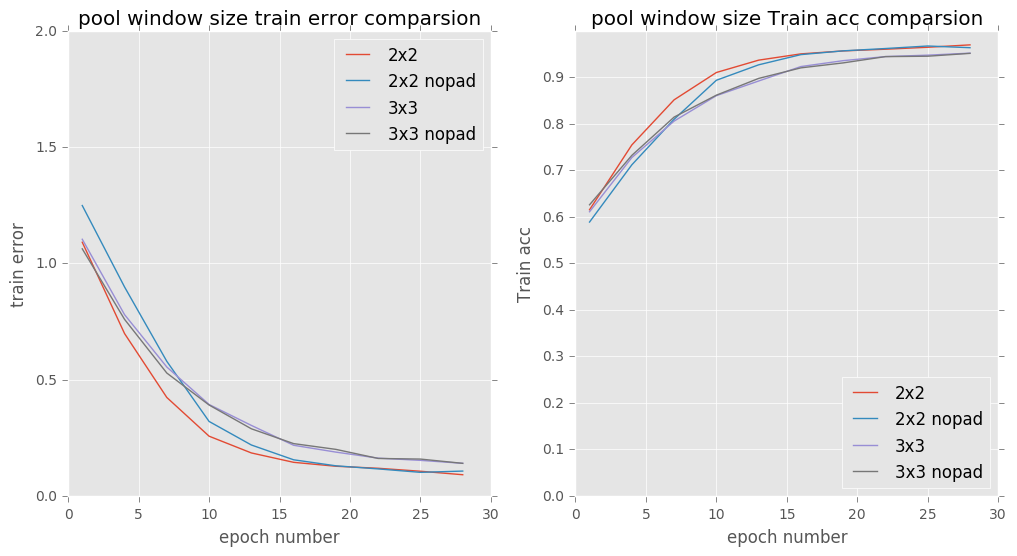

In [10]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
ax3 = fig.add_subplot(1, 2, 1)
ax4 = fig.add_subplot(1, 2, 2)
ax3.plot(np.arange(1,31,3),train_error_2by2, label='2x2')
ax3.plot(np.arange(1,31,3),train_error_2by2_nopad, label='2x2 nopad')
ax3.plot(np.arange(1,31,3),train_error_3by3, label='3x3')
ax3.plot(np.arange(1,31,3),train_error_3by3_nopad, label='3x3 nopad')
ax3.legend(loc='upper right')
ax3.set_xlabel('epoch number')
ax3.set_ylabel('train error')
ax3.set_title('pool window size train error comparsion')
ax3.set_ylim(0,2)
#ax3.set_yscale('log')
ax4.plot(np.arange(1,31,3),train_acc_2by2, label='2x2')
ax4.plot(np.arange(1,31,3),train_acc_2by2_nopad, label='2x2 nopad')
ax4.plot(np.arange(1,31,3),train_acc_3by3, label='3x3')
ax4.plot(np.arange(1,31,3),train_acc_3by3_nopad, label='3x3 nopad')
ax4.legend(loc='lower right')
ax4.set_xlabel('epoch number')
ax4.set_ylabel('Train acc')
ax4.set_title('pool window size Train acc comparsion')
#ax4.set_yscale('log')
ax4.set_yticks(np.arange(0,1,0.1))
plt.savefig("figure3.png")

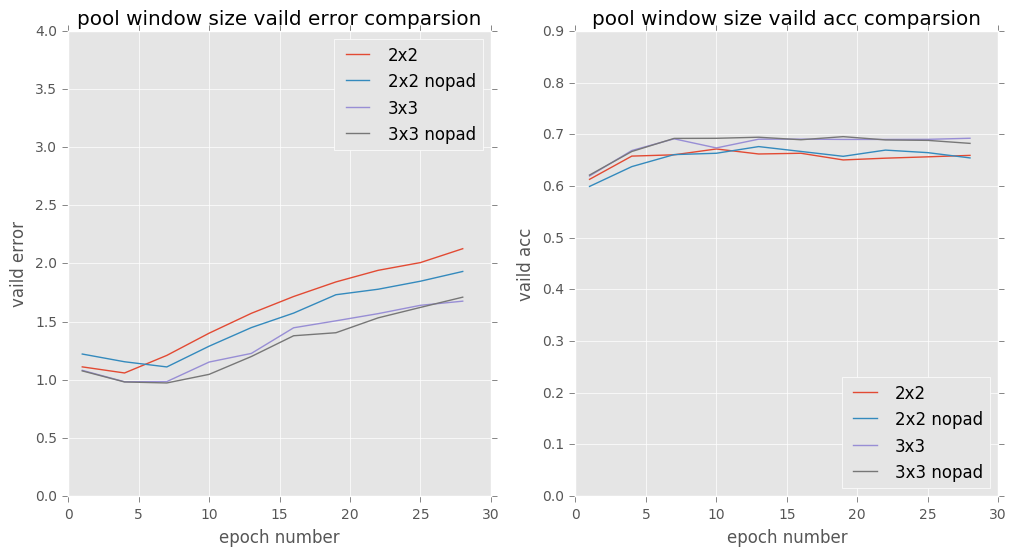

In [11]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(np.arange(1,31,3),vald_error_2by2, label='2x2')
ax1.plot(np.arange(1,31,3),vald_error_2by2_nopad, label='2x2 nopad')
ax1.plot(np.arange(1,31,3),vald_error_3by3, label='3x3')
ax1.plot(np.arange(1,31,3),vald_error_3by3_nopad, label='3x3 nopad')
ax1.legend(loc='upper right')
ax1.set_xlabel('epoch number')
ax1.set_ylabel('vaild error')
ax1.set_title('pool window size vaild error comparsion')
ax1.set_ylim(0,4)
ax2.plot(np.arange(1,31,3),vald_acc_2by2, label='2x2')
ax2.plot(np.arange(1,31,3),vald_acc_2by2_nopad, label='2x2 nopad')
ax2.plot(np.arange(1,31,3),vald_acc_3by3, label='3x3')
ax2.plot(np.arange(1,31,3),vald_acc_3by3_nopad, label='3x3 nopad')
ax2.legend(loc='lower right')
ax2.set_xlabel('epoch number')
ax2.set_ylabel('vaild acc')
ax2.set_title('pool window size vaild acc comparsion')
ax2.set_yticks(np.arange(0,1,0.1))
plt.savefig("figure4.png")

In [ ]:
def two_cnv_fc_layer_overlapping(inputs, AF,ksize,padding):
    with tf.variable_scope('conv1'):
        #first Conv layer
        #kernel is a 5x5 weights matrix for all 3 colors, used truncated to randomlize it
        conv_kernel_1 = tf.Variable(
        tf.truncated_normal(
        shape=[5, 5, 3, 32], stddev=0.05),'kernel')
        #do the convlove
        conv1 = tf.nn.conv2d(inputs, conv_kernel_1, [1, 1, 1, 1], padding='SAME')
        #define bias:0
        conv_bias_1 = tf.Variable(tf.zeros([32]), 'biases')
        conv1_add_bias = tf.nn.bias_add(conv1, conv_bias_1)
        #non_lineartity
        AF_conv1 = AF(conv1_add_bias)
        #pooling layer
        
    max_pool_1 = tf.nn.max_pool(AF_conv1, ksize=ksize, strides=[1, 1, 1, 1],
                                  padding=padding, name='pool1_layer')
        # normalization
    norm_1 = tf.nn.lrn(max_pool_1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm1')
    
    with tf.variable_scope('conv2') :
        #kernel is a 3x3 weights matrix for all 64 features, used truncated to randomlize it
        conv_kernel_2 = tf.Variable(
        tf.truncated_normal(
        shape=[5, 5, 32, 64], stddev=0.05),'kernel')
        #do the convlove
        conv2 = tf.nn.conv2d(norm_1, conv_kernel_2, [1, 1, 1, 1], padding='SAME')
        #define bias: 0
        conv_bias_2 = tf.Variable(tf.zeros([64]), 'biases')
        conv2_add_bias = tf.nn.bias_add(conv2, conv_bias_2)
        #apply non-lineartity
        AF_conv2 = AF(conv2_add_bias)
    # local-response-normalization
    norm_2 = tf.nn.lrn(AF_conv2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm2')
    #pooling
    max_pool_2 = tf.nn.max_pool(norm_2, ksize=ksize, strides=[1, 2, 2, 1],
                              padding=padding , name='pool2_layer')
    
    #reshape the image for fc-layers and get the dim
    reshaped_image = tf.reshape(max_pool_2, [-1,8*8*64])
    #reshaped_dim = reshaped_image.get_shape()[1].value
    #first fc-layer
    with tf.variable_scope('fc_layer1'):
        #let the hidden layer has 384 nodes
        fc_weights1 = tf.Variable(tf.truncated_normal(shape=[8*8*64,1024], stddev=0.05),
                                  'fc_weights1')
        fc_bias1 = tf.Variable(tf.zeros([1024]),'fc_bias1')
        Wx_b = tf.matmul(reshaped_image,fc_weights1) + fc_bias1
        Wx_b = tf.nn.dropout(Wx_b,keep_prob=0.5)
        fc_layer_1 = AF(Wx_b)
    #second fc-layer
    with tf.variable_scope('fc_layer2'):
        fc_weights2 = tf.Variable(tf.truncated_normal(shape=[1024,1024],stddev=0.05),
                                 'fc_weights2')
        fc_bias2 = tf.Variable(tf.zeros([1024]),'fc_bias2')
        Wx_b2 = tf.matmul(fc_layer_1,fc_weights2) + fc_bias2
        Wx_b2 = tf.nn.dropout(Wx_b2,keep_prob=0.5)
        fc_layer_2 = AF(Wx_b2)        
    #output layer
    with tf.variable_scope('fc_output'):
        fc_weights3 = tf.Variable(tf.truncated_normal(shape=[1024,train_data_10.num_classes],
                                                      stddev=0.05),'fc_weights3')
        fc_bias3 = tf.Variable(tf.zeros([train_data_10.num_classes]),'fc_bias3')
        outputs=AF(tf.add(tf.matmul(fc_layer_2,fc_weights3),fc_bias3))
    return outputs